In [1]:
import sys
sys.path.append("/ocean/projects/cis240129p/soederha/silent_speech")

import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Subset, ConcatDataset
from pathlib import Path
import numpy as np
from lib_alice import BrennanDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm.notebook import tqdm

base_dir = Path("/ocean/projects/cis240129p/shared/data/eeg_alice")
subjects_used = ["S04", "S13", "S19"]  # exclude 'S05' - less channels


In [2]:
def create_datasets(subjects, base_dir, augmented_eeg_dict = None):
    train_datasets = []
    test_datasets = []
    for subject in subjects:
        dataset = BrennanDataset(
            root_dir=base_dir,
            phoneme_dir=base_dir / "phonemes",
            idx=subject,
            phoneme_dict_path=base_dir / "phoneme_dict.txt",
            augmented_eeg_dict=augmented_eeg_dict,
        )
        num_data_points = len(dataset)

        # Split indices into train and test sets
        split_index = int(num_data_points * 0.8)
        train_indices = list(range(split_index))
        test_indices = list(range(split_index, num_data_points))

        # Create Subset datasets using indices
        train_dataset = Subset(dataset, train_indices)
        test_dataset = Subset(dataset, test_indices)

        train_datasets.append(train_dataset)
        test_datasets.append(test_dataset)
    return train_datasets, test_datasets


train_ds, test_ds = create_datasets(subjects_used, base_dir)
train_dataset = ConcatDataset(train_ds)
test_dataset = ConcatDataset(test_ds)
print(
    f"Train dataset length: {len(train_dataset)}, Test dataset length: {len(test_dataset)}"
)

Extracting parameters from /ocean/projects/cis240129p/shared/data/eeg_alice/S04.vhdr...
Setting channel info structure...
Reading 0 ... 368449  =      0.000 ...   736.898 secs...
Extracting parameters from /ocean/projects/cis240129p/shared/data/eeg_alice/S13.vhdr...
Setting channel info structure...
Reading 0 ... 368274  =      0.000 ...   736.548 secs...
Extracting parameters from /ocean/projects/cis240129p/shared/data/eeg_alice/S19.vhdr...
Setting channel info structure...
Reading 0 ... 373374  =      0.000 ...   746.748 secs...
Train dataset length: 5109, Test dataset length: 1278


In [3]:
print(train_dataset[2])

eeg raw shape3: (520, 60)
eeg feats shape: (159, 300)
{'label': 'beginning', 'audio_feats': array([[ -9.501374 ,  -9.728448 , -10.021716 , ...,  -6.9363112,
         -7.046369 , -10.906834 ],
       [ -9.535726 ,  -9.078351 ,  -8.7449045, ...,  -7.1128097,
         -8.158176 , -11.344505 ],
       [-11.360717 , -10.381192 ,  -9.873763 , ...,  -8.014458 ,
         -9.281037 , -11.204559 ],
       ...,
       [ -7.576384 ,  -7.801605 ,  -8.088927 , ..., -11.23759  ,
        -11.469321 , -11.512723 ],
       [ -9.226811 ,  -8.89115  ,  -8.620725 , ..., -11.165502 ,
        -11.387218 , -11.511845 ],
       [ -8.664348 ,  -8.714449 ,  -8.755628 , ..., -11.25327  ,
        -11.440603 , -11.509818 ]], dtype=float32), 'audio_raw': array([-0.00564938,  0.03451216, -0.04623905, ..., -0.01230818,
       -0.01343718, -0.01837567]), 'eeg_raw': array([[ 0.13822063,  0.11013473,  0.18283209, ...,  0.24540294,
         0.8581372 ,  0.47406291],
       [ 0.50044492,  0.6891782 ,  0.84550396, ...,  0.5

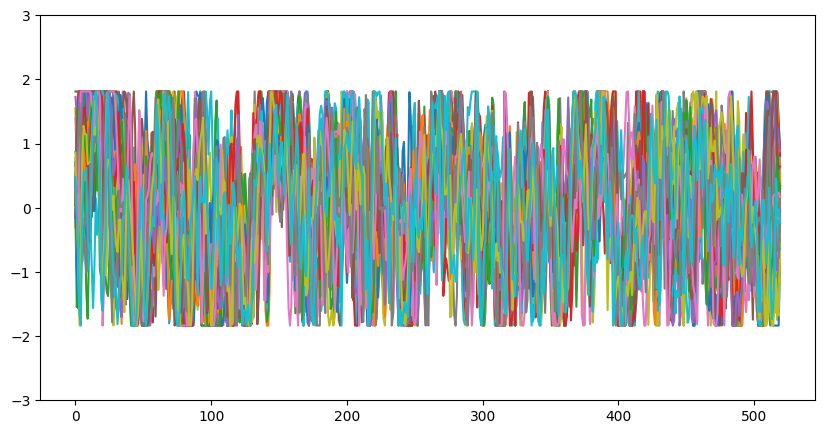

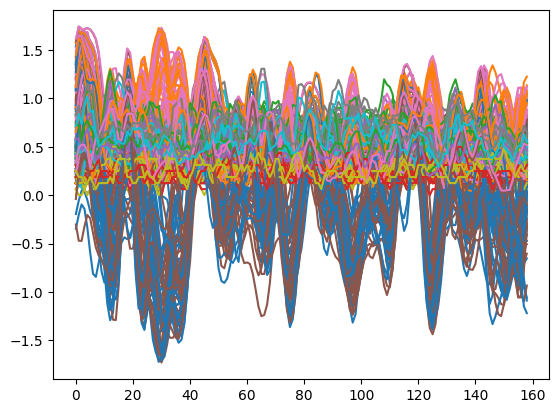

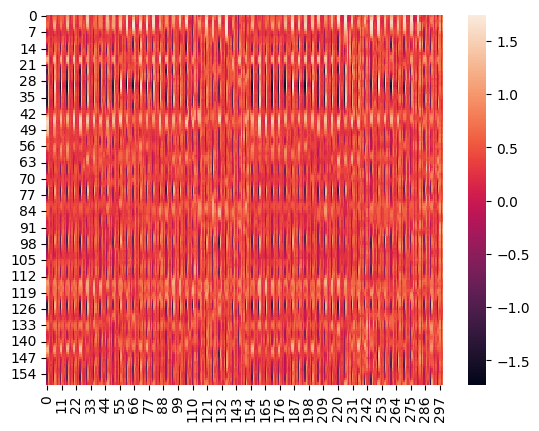

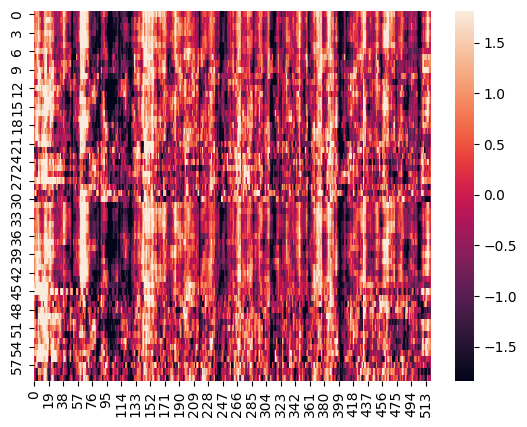

In [16]:
#plot eeg raw vs eeg feat

eeg_raw = train_dataset[2]["eeg_raw"]
eeg_feat = train_dataset[2]["eeg_feats"]

plt.figure(figsize=(10, 5))
plt.ylim(-3, 3)
plt.plot(eeg_raw)
plt.show()

plt.plot(eeg_feat)
plt.show()

import seaborn as sns

sns.heatmap(eeg_feat)
plt.show()

sns.heatmap(eeg_raw.T)
plt.show()

In [6]:
def collate_fn(batch):
    """
    A custom collate function that handles different types of data in a batch.
    It dynamically creates batches by converting arrays or lists to tensors and
    applies padding to variable-length sequences.
    """
    batch_dict = {}
    for key in batch[0].keys():
        batch_items = [item[key] for item in batch]
        if isinstance(batch_items[0], np.ndarray) or isinstance(
            batch_items[0], torch.Tensor
        ):
            if isinstance(batch_items[0], np.ndarray):
                batch_items = [torch.tensor(b) for b in batch_items]
            if len(batch_items[0].shape) > 0:
                batch_dict[key] = torch.nn.utils.rnn.pad_sequence(
                    batch_items, batch_first=True  # pad with zeros
                )
            else:
                batch_dict[key] = torch.stack(batch_items)
        else:
            batch_dict[key] = batch_items

    return batch_dict


train_dataloder = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=2,
    num_workers=1,
    shuffle=True,
    collate_fn=collate_fn,
)

test_dataloder = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=2,
    num_workers=1,
    shuffle=False,
    collate_fn=collate_fn,
)

In [18]:
i=0
for batch in train_dataloder:
    print(type(batch))
    print(batch.keys())
    print(batch['eeg_raw'].shape)
    #print(batch['label'])
    #print(batch['eeg_feats'].shape)
    
    print(batch['label'])
    i+=1
    if i>1:
        break

<class 'dict'>
dict_keys(['label', 'audio_feats', 'audio_raw', 'eeg_raw', 'eeg_feats', 'phonemes', 'eeg_augmented'])
torch.Size([2, 520, 60])
['What', 'neck']
<class 'dict'>
dict_keys(['label', 'audio_feats', 'audio_raw', 'eeg_raw', 'eeg_feats', 'phonemes', 'eeg_augmented'])
torch.Size([2, 520, 60])
['of', 'see']


In [4]:
class EEGAutoencoder(nn.Module):
    def __init__(self, sequence_lenth=520, feature_dim=60,latent_dim=256):
        super(EEGAutoencoder, self).__init__()
        
        self.input_dim = sequence_lenth * feature_dim
        self.sequence_length = sequence_lenth
        self.feature_dim = feature_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
        )
        
        
        '''self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3,3), stride=(2,1), padding=(1,1)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=(3,3), stride=(2,1), padding=(1,1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )'''
        
        #for convolutional
        '''x = torch.randn(1, 1, self.sequence_length, feature_dim)
        x = self.encoder(x)
        self.flattened_size = x.shape[1] * x.shape[2] * x.shape[3]
        self.conv_shape = x.shape[1:]'''
        
        # Latent space
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_var = nn.Linear(512, latent_dim)
        
        '''# Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, self.input_dim),
            nn.Tanh()
        )'''
        
        #self.decoder_input = nn.Linear(latent_dim, 1024)
        
        '''self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=(3,3), stride=(2,1), padding=(1,1), output_padding=(1,0)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=(3,3), stride=(2,1), padding=(1,1), output_padding=(1,0)),
            nn.Tanh()
        )'''
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, self.input_dim),
            nn.Tanh()
        )
        
        
        
    def encode(self, x):
        x = x.view(x.size(0), -1)  #flattens to 2dim, for linear layers
        #x = x.unsqueeze(1)   #for convolutional
        x = self.encoder(x) 
        #x = x.view(x.size(0), -1)    #for convolutional
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    #decode for linear
    def decode(self, z):
        x = self.decoder(z)
        return x.view(-1, self.sequence_length, self.feature_dim)
        
    #decode for convolutional
    '''def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(-1, *self.conv_shape)
        x = self.decoder(x)
        return x.squeeze(1) '''
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

def train_eeg_vae(model, train_loader, optimizer, device, epoch):
    model.train()
    total_loss = 0
    total_recon_loss = 0
    total_kld_loss = 0
    
    running_loss = 0.0
    running_recon_loss = 0.0
    running_kld_loss = 0.0
    
    batch_pbar = tqdm(train_dataloder, desc=f'Epoch {epoch}', leave=False)
    
    for batch_idx, batch in enumerate(batch_pbar):
        eeg_feats = batch['eeg_raw'].float().to(device)
        optimizer.zero_grad()
        
        #Forward
        recon_batch, mu, log_var = model(eeg_feats)
        
        #Loss
        #reconstruction_loss = F.mse_loss(recon_batch, eeg_feats.view(recon_batch.shape), reduction='sum')
        reconstruction_loss = F.mse_loss(recon_batch, eeg_feats, reduction='sum')/eeg_feats.shape[0]
        kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())/eeg_feats.shape[0]
        
        #Total loss
        beta = 0.1  # control KL divergence impact
        loss = reconstruction_loss + beta * kld_loss
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_recon_loss += reconstruction_loss.item()
        total_kld_loss += kld_loss.item()
        
        running_loss += loss.item()
        current_loss = running_loss / (batch_idx + 1)
        
        running_recon_loss += reconstruction_loss.item()
        current_recon_loss = running_recon_loss / (batch_idx + 1)
        
        running_kld_loss += kld_loss.item()
        current_kld_loss = running_kld_loss / (batch_idx + 1)
        
        batch_pbar.set_postfix({
                'loss': f'{current_loss:.4f}',
                'recon': f'{current_recon_loss:.4f}',
                'kld': f'{current_kld_loss:.4f}'
            })
        
        
        
        '''if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx}]\t'
                  f'Loss: {loss.item() / len(eeg_feats):.6f}'
                  f'Reconstruction Loss: {reconstruction_loss.item() / len(eeg_feats):.6f}'
                  f'KLD Loss: {kld_loss.item() / len(eeg_feats):.6f}')
          '''  
    avg_loss = total_loss / len(train_loader.dataset)
    return avg_loss

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

model = EEGAutoencoder(sequence_lenth=520, feature_dim=60, latent_dim=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

from torchsummaryX import summary
test =  torch.zeros(2, 520, 60).to(device)
summary(model, test)

num_epochs = 1
train_losses = []
for epoch in range(1, num_epochs + 1):
    train_loss = train_eeg_vae(model, train_dataloder, optimizer, device, epoch)
    train_losses.append(train_loss)
    print(f'====> Epoch: {epoch} Average loss: {train_loss:.4f}')

Device: cuda
----------------------------------------------------------------------------------------------------
Layer                   Kernel Shape         Output Shape         # Params (K)      # Mult-Adds (M)
0_Linear               [31200, 1024]            [2, 1024]            31,949.82                31.95
1_ReLU                             -            [2, 1024]                    -                    -
2_Linear                 [1024, 512]             [2, 512]               524.80                 0.52
3_ReLU                             -             [2, 512]                    -                    -
4_Linear                   [512, 64]              [2, 64]                32.83                 0.03
5_Linear                   [512, 64]              [2, 64]                32.83                 0.03
6_Linear                   [64, 512]             [2, 512]                33.28                 0.03
7_ReLU                             -             [2, 512]                    -        

Epoch 1:   0%|          | 0/2555 [00:00<?, ?it/s]

eeg raw shape3: (520, 60)
eeg feats shape: (159, 300)
eeg raw shape3: (520, 60)
eeg feats shape: (159, 300)
eeg raw shape3: (520, 60)
eeg feats shape: (159, 300)
eeg raw shape3: (520, 60)
eeg feats shape: (159, 300)
eeg raw shape3: (520, 60)
eeg feats shape: (159, 300)
eeg raw shape3: (520, 60)
eeg feats shape: (159, 300)
eeg raw shape3: (520, 60)
eeg feats shape: (159, 300)
eeg raw shape3: (520, 60)
eeg feats shape: (159, 300)
eeg raw shape3: (520, 60)
eeg feats shape: (159, 300)
eeg raw shape3: (520, 60)
eeg feats shape: (159, 300)
eeg raw shape3: (520, 60)
eeg feats shape: (159, 300)
eeg raw shape3: (520, 60)
eeg feats shape: (159, 300)
eeg raw shape3: (520, 60)
eeg feats shape: (159, 300)
eeg raw shape3: (520, 60)
eeg feats shape: (159, 300)
eeg raw shape3: (520, 60)
eeg feats shape: (159, 300)
eeg raw shape3: (520, 60)
eeg feats shape: (159, 300)
eeg raw shape3: (520, 60)
eeg feats shape: (159, 300)
eeg raw shape3: (520, 60)
eeg feats shape: (159, 300)
eeg raw shape3: (520, 60)
ee

In [19]:
def get_latent_by_word(model, train_dataloder, word_target):
    """
    Get the mean latent vector for a specific word from the training data
    """
    model.eval()
    device = next(model.parameters()).device
    
    word_latents = []
    
    with torch.no_grad():
        for batch in tqdm(train_dataloder):
            labels = batch['label']
            eeg_feats = batch['eeg_feats'].float().to(device)
            
            # Find indices of the word target
            word_indices = [i for i, label in enumerate(labels) if label == word_target]
            
            if word_indices:
                # EEG features for the word
                word_eeg = eeg_feats[word_indices]
                
                # latent representations
                mu, _ = model.encode(word_eeg)
                word_latents.append(mu)
    if word_latents:
        word_latents = torch.cat(word_latents, dim=0)
        mean_latent = torch.mean(word_latents, dim=0)
        var_latent = torch.var(word_latents, dim=0)
        return mean_latent, var_latent
    else:
        return None, None

def generate_eeg_from_word(model, word, train_dataloder, num_samples=5):
    """
    Generate new EEG features for a given word
    """
    model.eval()
    device = next(model.parameters()).device
    
    # Get mean and variance of latent vectors for this word
    mean_latent, var_latent = get_latent_by_word(model, train_dataloder, word)
    
    if mean_latent is None:
        print(f"No samples found for word: {word}")
        return None
    
    # Generate samples
    generated_samples = []
    with torch.no_grad():
        for i in range(num_samples):
            # Sample from the word's latent distribution
            eps = torch.randn_like(var_latent)
            z = mean_latent + eps * torch.sqrt(var_latent)
            
            # Generate new EEG features
            generated = model.decode(z.unsqueeze(0))
            generated_samples.append(generated)
    
    return torch.cat(generated_samples, dim=0)

def analyze_generated_samples(model, word, train_dataloder, num_samples=5):
    """
    Generate a number of eeg data samples for a word and returns both original and new
    """
    #real samples
    real_samples = []
    real_found = False
    
    for batch in train_dataloder:
        labels = batch['label']
        eeg_feats = batch['eeg_feats']
        
        
        word_indices = [i for i, label in enumerate(labels) if label == word]
        if word_indices:
            real_found = True
            real_samples.append(eeg_feats[word_indices])
    
    if not real_found:
        print(f"No real samples found for word: {word}")
        return
    
    real_samples = torch.cat(real_samples, dim=0)
    
    #new samples
    generated_samples = generate_eeg_from_word(model, word, train_dataloder, num_samples)
    
    if generated_samples is None:
        return
        
    '''print(word)
    print("Real samples shape:", real_samples.shape)
    print("Generated samples shape:", generated_samples.shape)'''
    
    real_mean = torch.mean(real_samples, dim=0)
    real_std = torch.std(real_samples, dim=0)
    gen_mean = torch.mean(generated_samples, dim=0)
    gen_std = torch.std(generated_samples, dim=0)
    
    print("\nStatistics:")
    print(f"Real mean range: [{torch.min(real_mean):.3f}, {torch.max(real_mean):.3f}]")
    print(f"Generated mean range: [{torch.min(gen_mean):.3f}, {torch.max(gen_mean):.3f}]")
    print(f"Real std range: [{torch.min(real_std):.3f}, {torch.max(real_std):.3f}]")
    print(f"Generated std range: [{torch.min(gen_std):.3f}, {torch.max(gen_std):.3f}]")
    
    return real_samples, generated_samples


In [ ]:
get_latent_by_word(model, train_dataloder, 'Alice')

In [ ]:
samples = generate_eeg_from_word(model, 'Alice', train_dataloder, num_samples=5)
print(samples.shape) #torch.Size([5, 159, 310])

In [ ]:
real_alice, generated_alice = analyze_generated_samples(model, 'Alice', train_dataloder, num_samples=5)

  0%|          | 0/2555 [00:00<?, ?it/s]


Statistics:
Real mean range: [-0.451, 0.422]
Generated mean range: [-0.121, 0.079]
Real std range: [0.413, 1.361]
Generated std range: [0.000, 0.000]


think
Real mean range: [-0.062, 0.627]
Generated mean range: [-0.035, 0.589]
Real std range: [0.000, 0.238]
Generated std range: [0.000, 0.072]

Alice
Real mean range: [-0.041, 0.625]
Generated mean range: [-0.033, 0.592]
Real std range: [0.000, 0.202]
Generated std range: [0.000, 0.077]

In [75]:
def plot_eeg_comparison(real_samples, generated_samples, word, time_points=100):
    plt.figure(figsize=(15, 5))
    
    # Plot real samples
    plt.subplot(1, 2, 1)
    for i in range(min(5, len(real_samples))):
        plt.plot(real_samples[i, :time_points, 40].cpu().numpy(), alpha=0.5)
    plt.title(f'Real EEG for "{word}"')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    
    # Plot generated samples
    plt.subplot(1, 2, 2)
    for i in range(min(5, len(generated_samples))):
        plt.plot(generated_samples[i, :time_points, 40].cpu().numpy(), alpha=0.5)
    plt.title(f'Generated EEG for "{word}"')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()

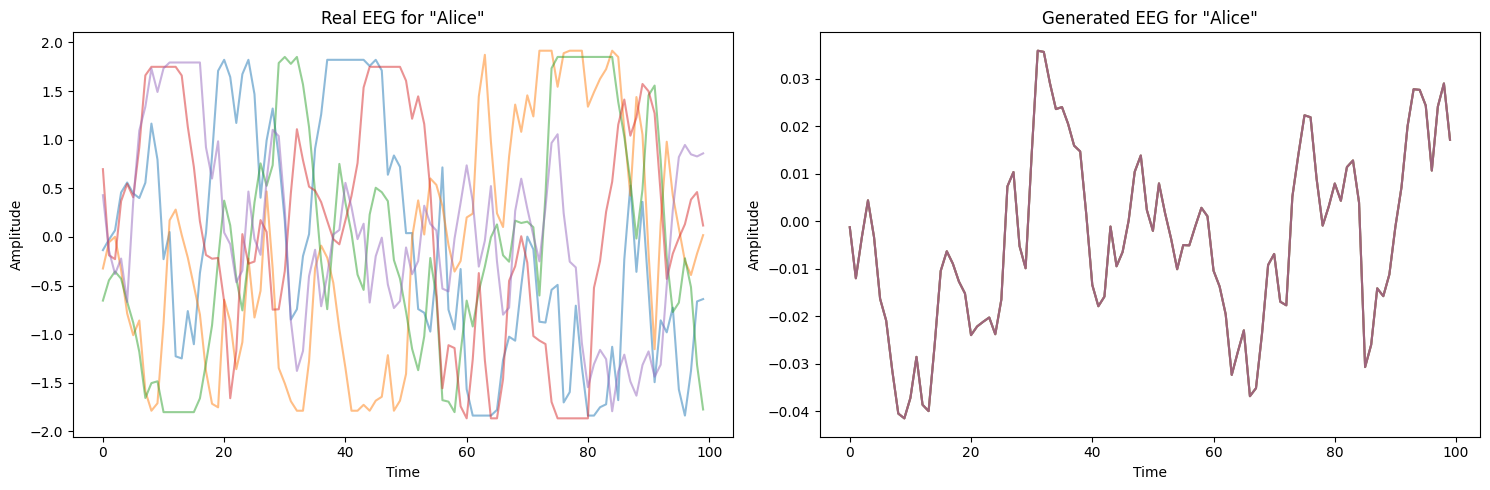

In [ ]:

plot_eeg_comparison(real_alice, generated_alice, 'Alice', time_points=100)

In [74]:
import seaborn as sns


def plot_eeg_heatmaps(real_sample, generated_sample, word):
   """
   Plot heatmap comparisons between real and generated EEG data
   
   Args:
       real_sample: Tensor of shape [sequence_length, feature_dim] containing real EEG data
       generated_sample: Tensor of shape [sequence_length, feature_dim] containing generated EEG data
       word: String indicating which word the samples represent
   """
   # Create figure
   fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
   
   # Plot real sample heatmap
   sns.heatmap(real_sample.cpu().numpy(), 
               ax=ax1, 
               cmap='viridis',
               cbar_kws={'label': 'Amplitude'})
   ax1.set_title(f'Real EEG Pattern for "{word}"')
   ax1.set_xlabel('Features')
   ax1.set_ylabel('Time Steps')
   
   # Plot generated sample heatmap
   sns.heatmap(generated_sample.cpu().numpy(), 
               ax=ax2, 
               cmap='viridis',
               cbar_kws={'label': 'Amplitude'})
   ax2.set_title(f'Generated EEG Pattern for "{word}"')
   ax2.set_xlabel('Features')
   ax2.set_ylabel('Time Steps')
   
   plt.tight_layout()
   plt.show()
   
   # Plot difference heatmap
   '''plt.figure(figsize=(10, 8))
   difference = real_sample.cpu().numpy() - generated_sample.cpu().numpy()
   sns.heatmap(difference, 
               cmap='RdBu',
               center=0,
               cbar_kws={'label': 'Difference (Real - Generated)'})
   plt.title(f'Difference Map for "{word}"')
   plt.xlabel('Features')
   plt.ylabel('Time Steps')
   plt.show()'''
   
   '''# Print statistics
   print(f"\nStatistics for {word}:")
   print(f"Real data range: [{real_sample.min():.3f}, {real_sample.max():.3f}]")
   print(f"Generated data range: [{generated_sample.min():.3f}, {generated_sample.max():.3f}]")'''

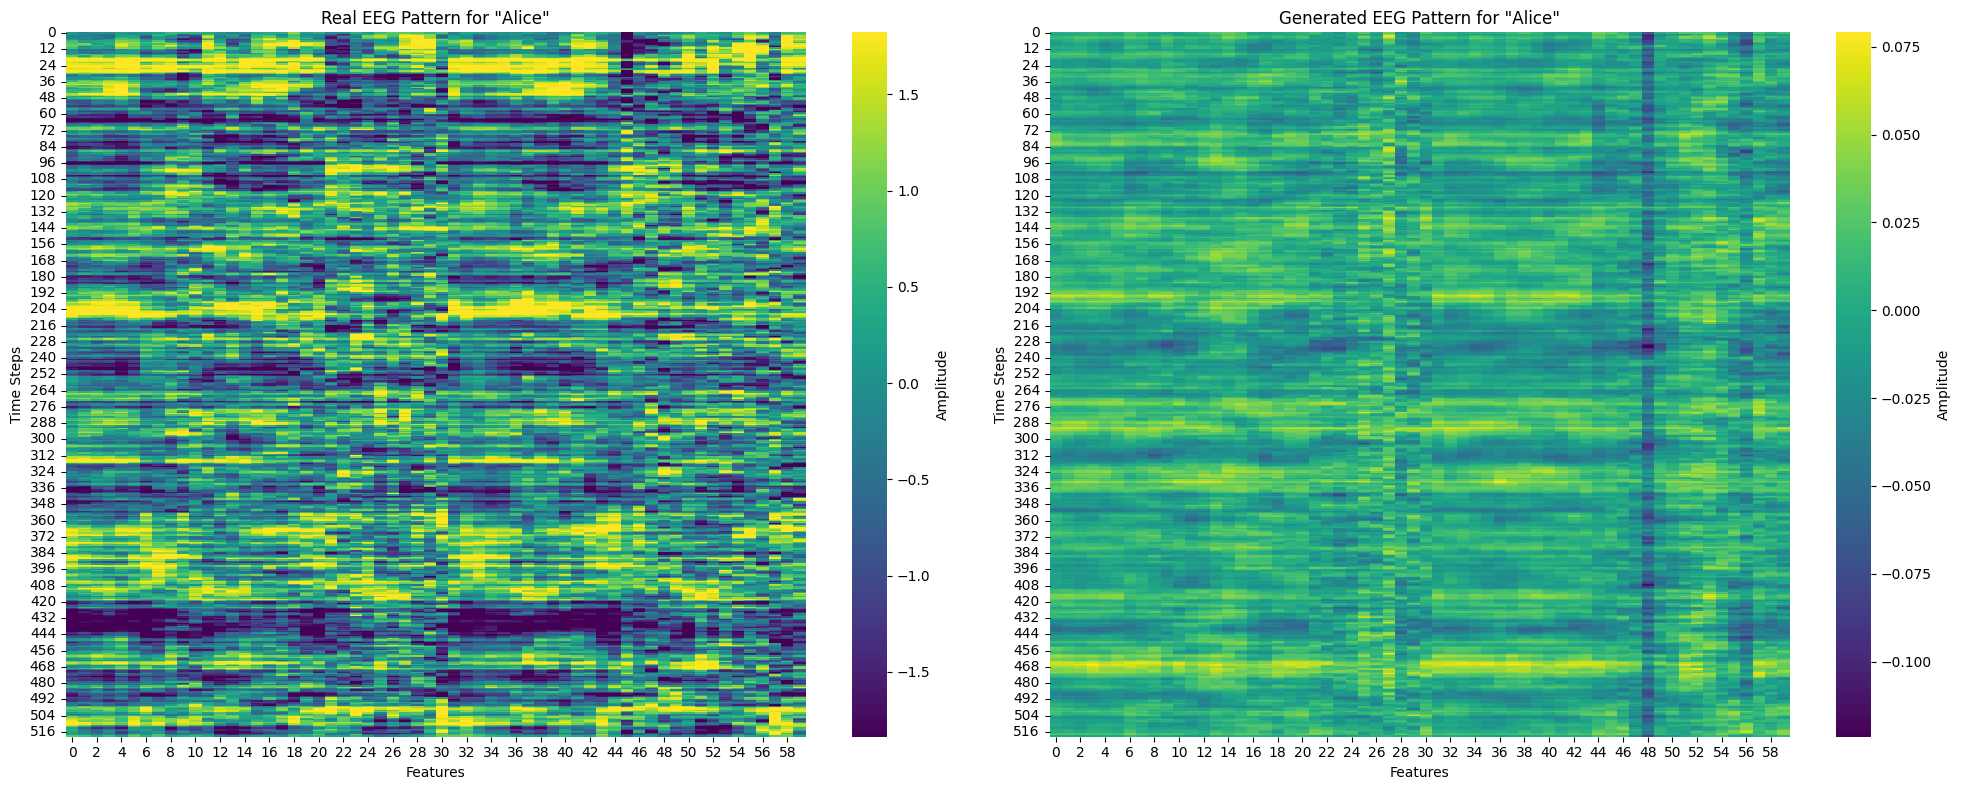

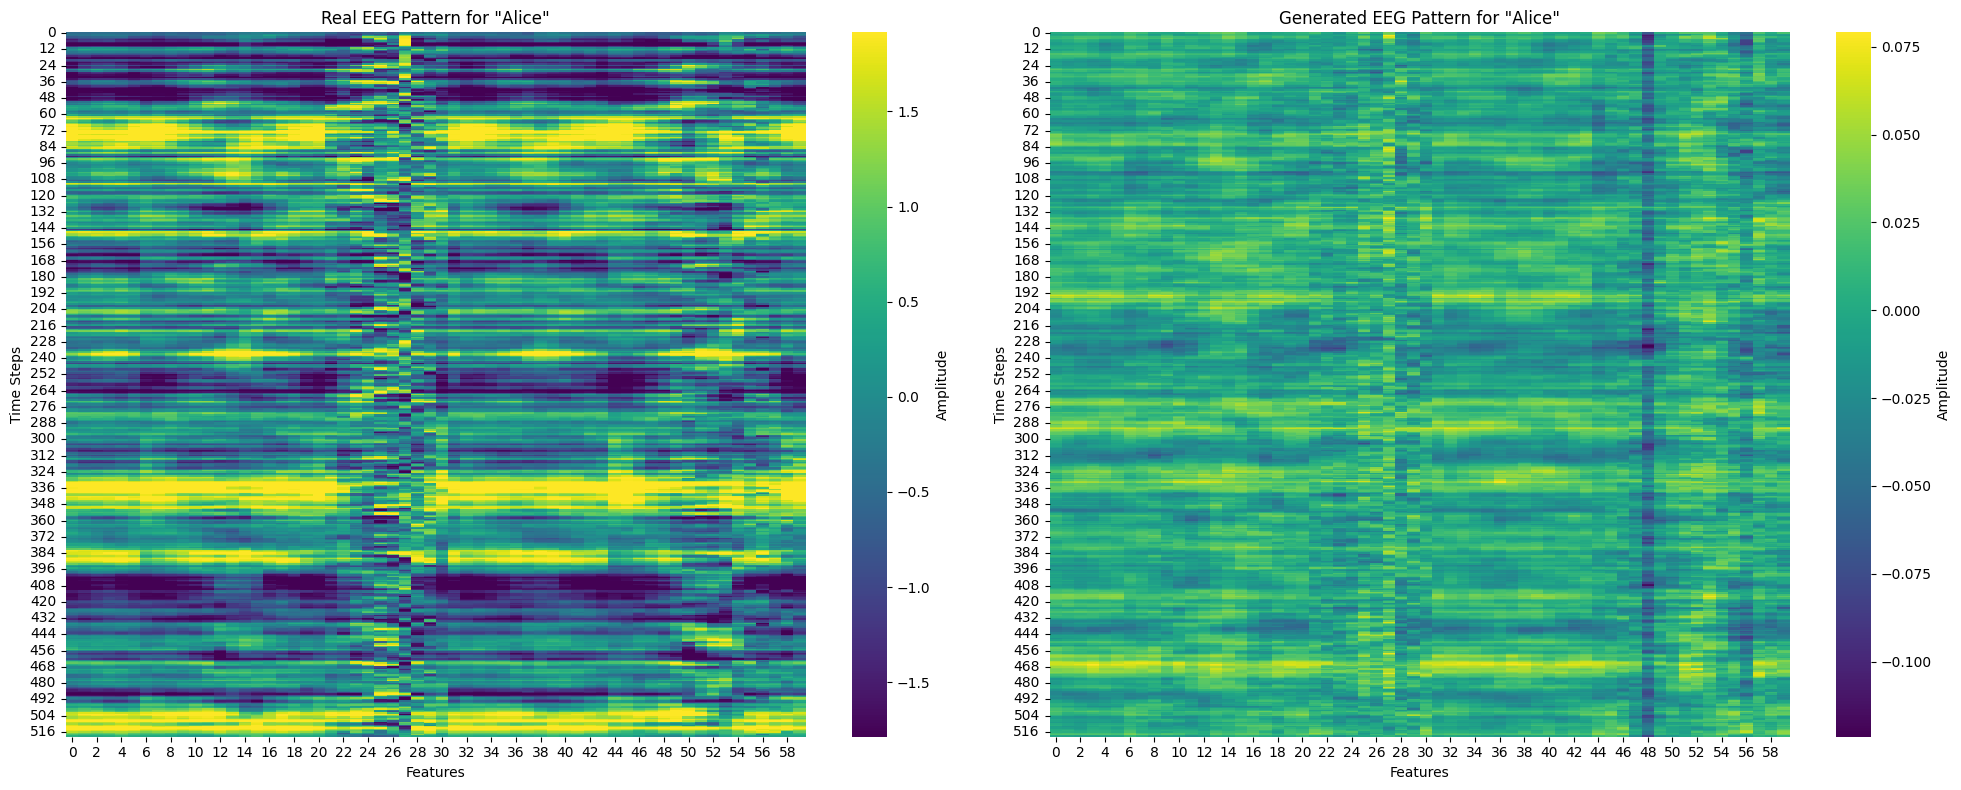

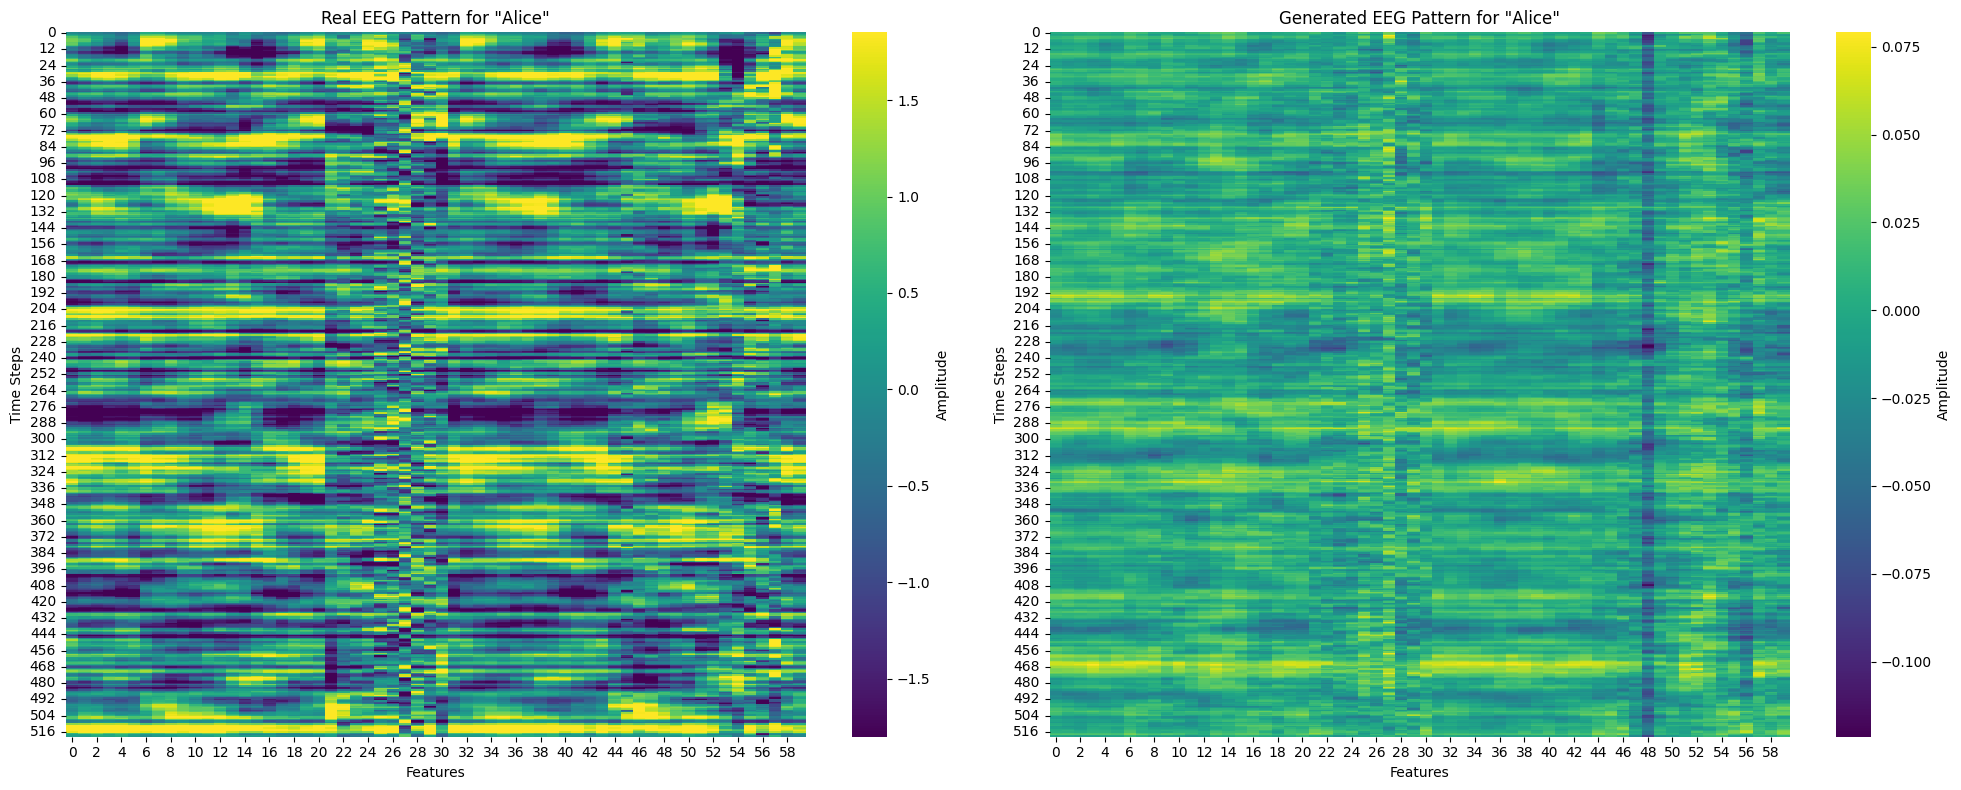

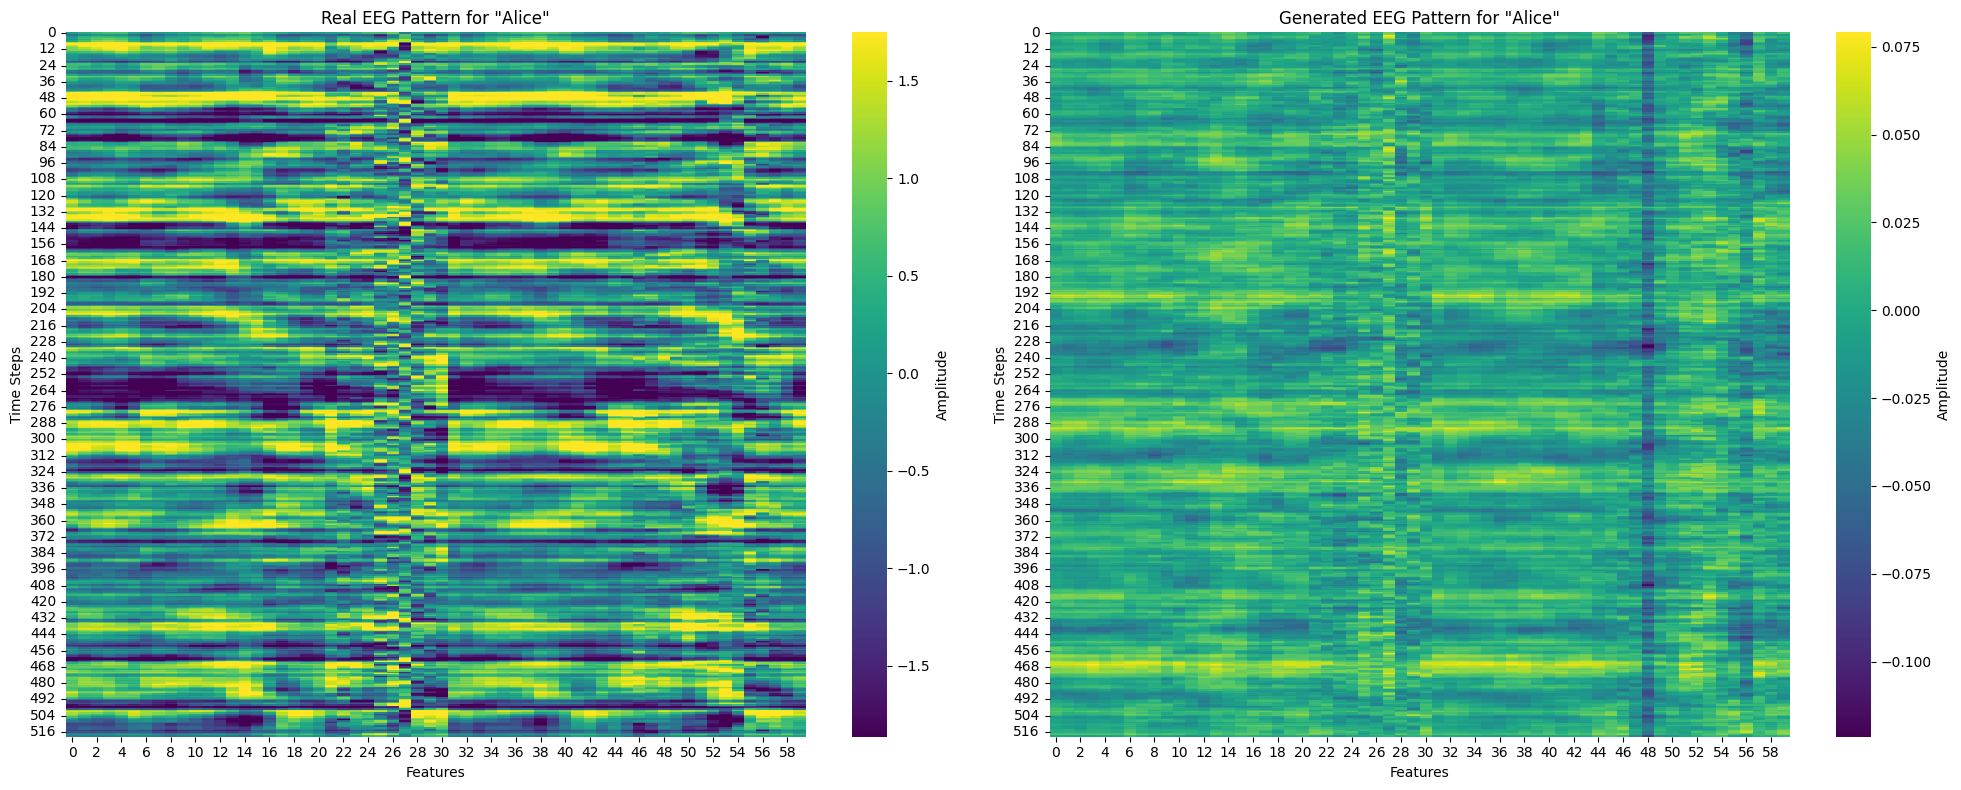

In [ ]:
plot_eeg_heatmaps(real_alice[0], generated_alice[0], 'Alice')
plot_eeg_heatmaps(real_alice[1], generated_alice[1], 'Alice')
plot_eeg_heatmaps(real_alice[2], generated_alice[2], 'Alice')
plot_eeg_heatmaps(real_alice[3], generated_alice[3], 'Alice')

  0%|          | 0/2555 [00:00<?, ?it/s]

[tensor([[ 0.4310, -0.0706,  0.4658, -0.5248,  0.0309,  1.7480,  0.3734,  0.3985,
          0.2560,  0.4212, -0.3274,  0.0155, -0.1108,  0.1048,  0.3396, -0.2861,
          0.4617,  0.4736, -0.1053, -0.0739, -0.2412,  0.1015,  0.1800, -0.5020,
         -0.5797,  0.5021,  0.4490,  0.4909,  0.2085,  0.2213,  0.0429, -0.5769,
          0.3544, -0.0561, -0.6333, -0.4397, -0.0225,  0.1398,  0.1419, -0.3692,
         -0.3810, -0.2825, -0.5643,  0.2859, -0.3786, -0.2659,  0.0392,  1.8111,
         -0.2741, -0.1419,  0.3022,  0.5875,  0.4563,  0.2401,  0.5398,  0.6479,
         -0.2736,  0.3214, -0.4809,  0.0240, -0.4061,  0.3264,  0.5246,  0.2470]],
       device='cuda:0'), tensor([[ 0.4113, -0.0615,  0.4305, -0.5039,  0.0266,  1.5711,  0.3654,  0.3894,
          0.2438,  0.4111, -0.3221,  0.0118, -0.1092,  0.1040,  0.3279, -0.2817,
          0.4439,  0.4366, -0.0862, -0.0542, -0.2298,  0.0887,  0.1688, -0.4783,
         -0.5525,  0.4785,  0.4311,  0.4712,  0.1966,  0.2111,  0.0417, -0.5420,


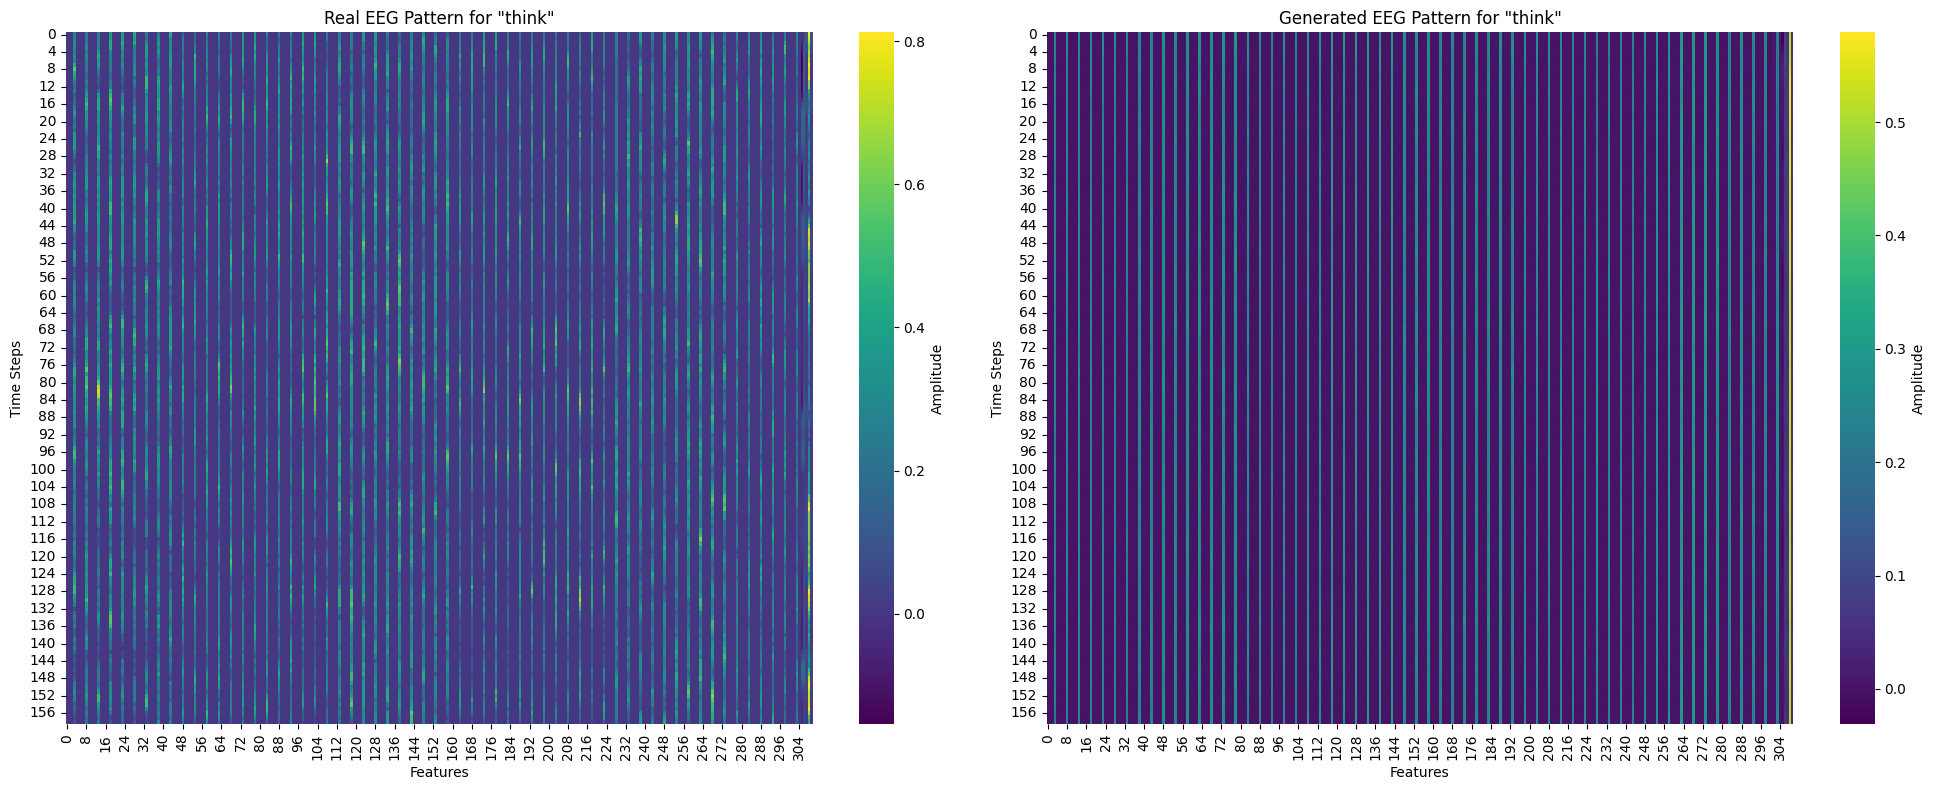

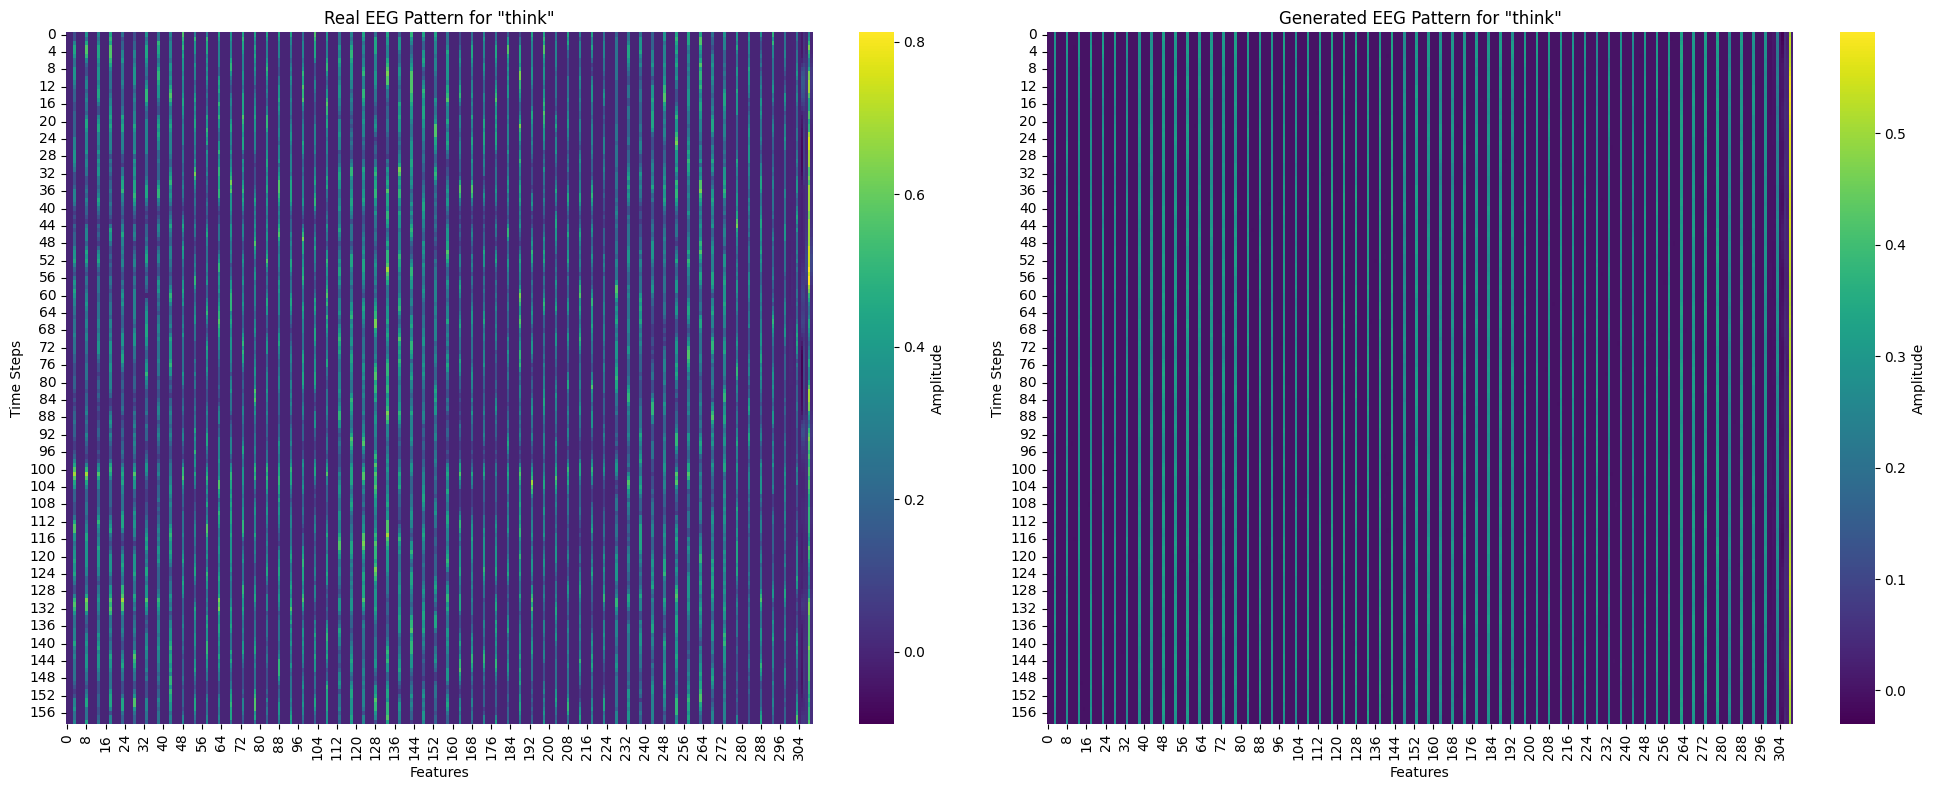

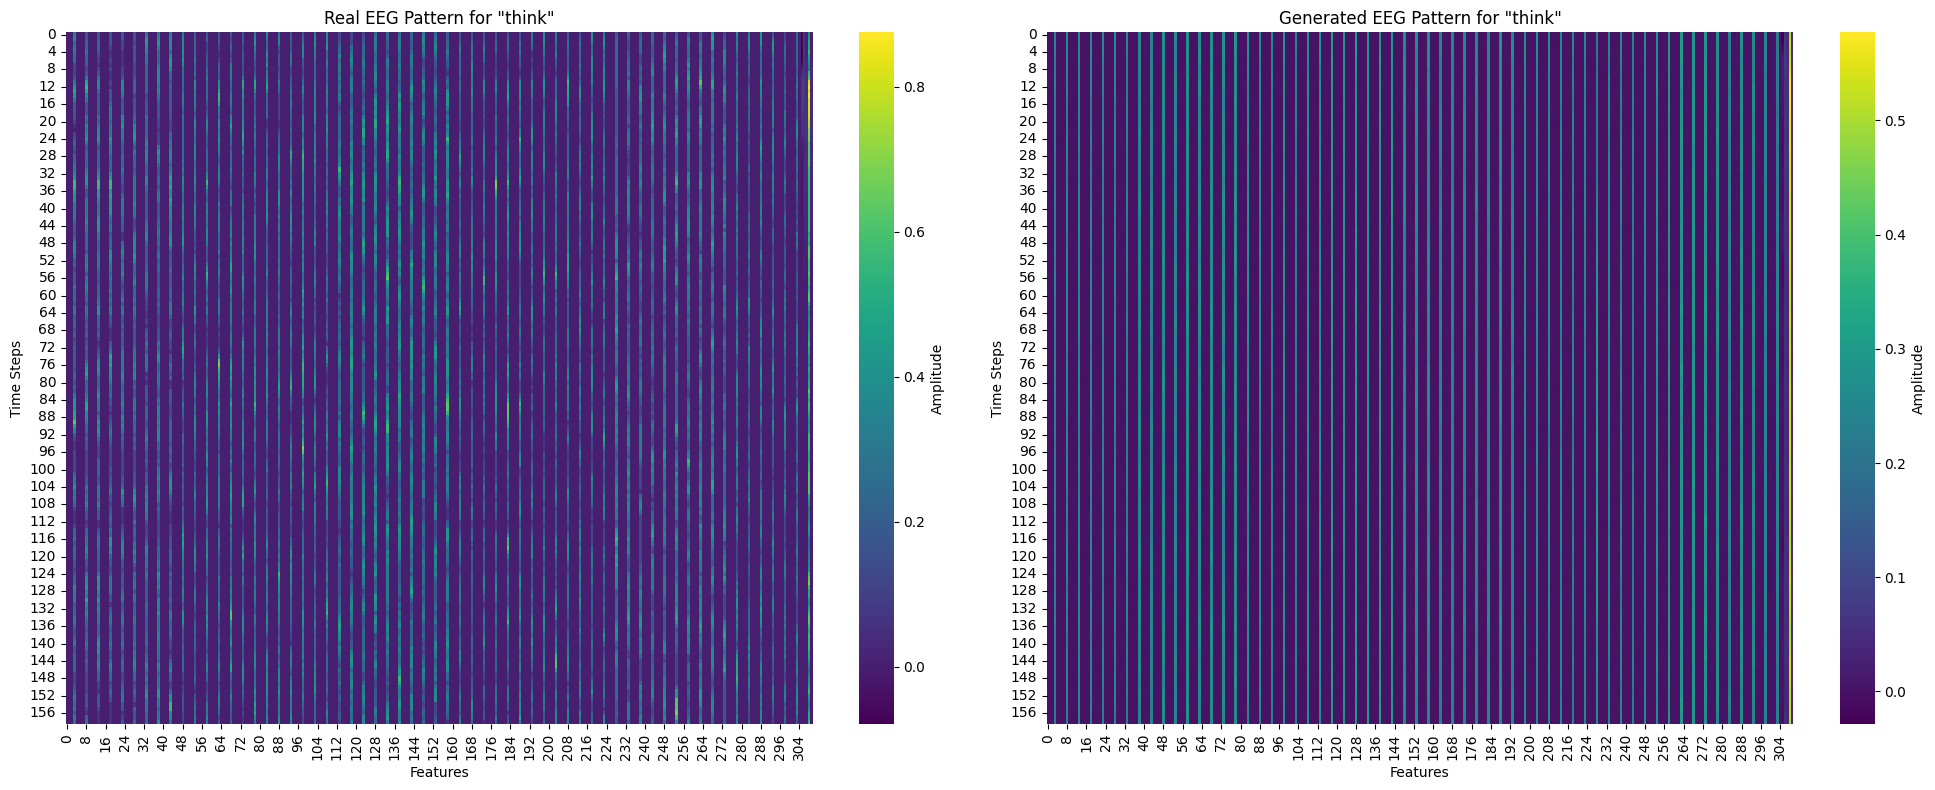

In [ ]:
real_think, generated_think = analyze_generated_samples(model, 'think', train_dataloder, num_samples=5)
plot_eeg_heatmaps(real_think[0], generated_think[0], 'think')
plot_eeg_heatmaps(real_think[1], generated_think[1], 'think')
plot_eeg_heatmaps(real_think[2], generated_think[2], 'think')

In [10]:
def word_latent_dict(model, train_dataloder):
    """ Returns dict of label:latent """
    model.eval()
    device = next(model.parameters()).device
    
    word_latents_dict = {}
    
    with torch.no_grad():
        #j=0
        for batch in tqdm(train_dataloder):
            #j+=1
            labels = batch['label']
            eeg_feats = batch['eeg_feats'].float().to(device)
            
            for i, label in enumerate(labels):
                if label not in word_latents_dict:
                    word_latents_dict[label] = []
                
                eeg_sample = eeg_feats[i]
                mu, _ = model.encode(eeg_sample.unsqueeze(0))   #mu is shape [1, 64]
                word_latents_dict[label].append(mu)
                
            #if j>500:
            #    break
            
                
    for key in word_latents_dict:
        word_latents_dict[key] = torch.cat(word_latents_dict[key], dim=0)
        
    return word_latents_dict

def mean_std_latent_dict(word_latents_dict):
    ''' calculates mean and std for each word in word_latents_dict '''
    mean_latent_dict = {}
    std_latent_dict = {}
    
    for key in word_latents_dict:
        mean_latent_dict[key] = torch.mean(word_latents_dict[key], dim=0)
        std_latent_dict[key] = torch.std(word_latents_dict[key], dim=0)
        
    return mean_latent_dict, std_latent_dict

def word_augmentation_dict(mean_latent_dict, std_latent_dict, num_samples=5):
    """ Creates dict with word:generated_samples (shape #generated x time x features) """
    word_augmentation_dict = {}
    
    for key in mean_latent_dict:
        word_augmentation_dict[key] = []
        for i in range(num_samples):
            eps = torch.randn_like(std_latent_dict[key])
            z = mean_latent_dict[key] + eps * torch.sqrt(std_latent_dict[key])
            generated = model.decode(z.unsqueeze(0))
            word_augmentation_dict[key].append(generated)
            
        word_augmentation_dict[key] = torch.cat(word_augmentation_dict[key], dim=0)
    
    return word_augmentation_dict

In [11]:
test_dict = word_latent_dict(model, train_dataloder)

  0%|          | 0/2555 [00:00<?, ?it/s]

In [12]:
print(test_dict['pop'].shape)

torch.Size([3, 64])


In [13]:
test_avaraged_dict, test_std_dict = mean_std_latent_dict(test_dict)
print(test_avaraged_dict['pop'].shape)

torch.Size([64])


In [14]:
print(len(test_avaraged_dict))
print(len(test_std_dict))
print(len(set(test_avaraged_dict.keys())))

553
553
553


In [15]:
test_augmentation_dict = word_augmentation_dict(test_avaraged_dict, test_std_dict, num_samples=5)

In [16]:
print(test_augmentation_dict['you'].shape)

torch.Size([5, 159, 300])
